#  Principle Component Analysis (PCA)

__Iris Dataset PCA 수행하기__

In [0]:
%matplotlib inline
import tensorflow as tf
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import pandas as pd

In [0]:
iris_dataset = datasets.load_iris()

data = iris_dataset.data
target = iris_dataset.target

Dataframe으로 데이터 확인

In [0]:
df = pd.DataFrame(data,columns=iris_dataset.feature_names)
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Plotting 하여 데이터 분포 시각화
<br>
 => Decision boundary 명확하지 않음을 직관

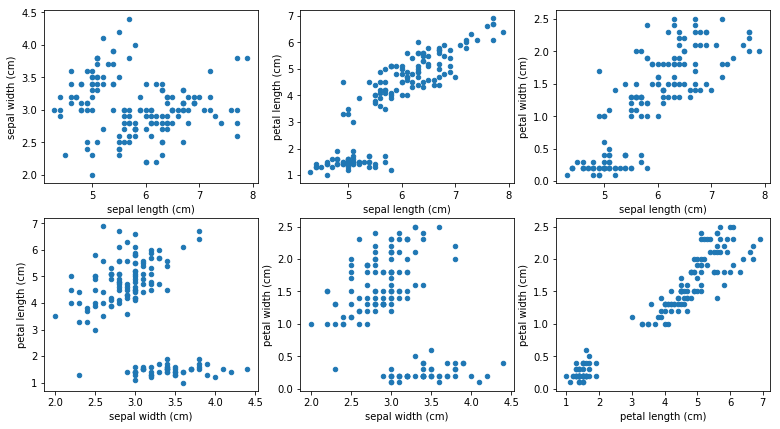

In [0]:
fig = plt.figure(figsize=(13,7))

c = 1
for idx, x_col in enumerate(df.columns):
    for y_col in df.columns[idx+1:]:
        ax = fig.add_subplot(2, 3, c)
        c+=1
        df.plot(x=x_col,
                y=y_col,
                ax=ax,
                kind='scatter')
plt.show()        

__텐서플로우기반의 PCA수행__
<br>
1. Covariance Matrix 구하기, 이때 각 feature의 평균을 0으로 scale
  * $COV(X) = \frac{1}{n-1} X^TX$
  
2. 공분산 행렬의 Eigen decomposition수행
   * $Xu = \lambda u$
   
3. 독립적인 M개의 축 중에서, 분산이 큰 순서대로 K개의 축(principal Component)를 추출= > EigenValue 추출
   * $W_d = 
\begin{bmatrix}
\vdots & \vdots & \vdots &  & \vdots \\
PC_1    & PC_2    & PC_3    & \cdots & PC_k \\
\vdots & \vdots & \vdots &  & \vdots\\
\end{bmatrix}
$
4. 위의 PC로 mapping Matrix를 구해서, raw 이미지에 적용
   * $X_{d-proj} = X \cdot W_d$

1. 텐서플로우 Grpah 구성하기

In [0]:
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32,(None,None), name='x')
    # 몇개의 pc를 뽑을건지 place홀더로 만듬
    num_pc = tf.placeholder_with_default(2, None, name="num_pc")
    

2. 공분산 행렬 구성하기 <br> 공분산 행렬의 각 원소들은 각 특징 간 **공분산** 정도를 나타냄<br>


In [0]:
with graph.as_default():
    # Calculate Covariance Matrix
    with tf.variable_scope("covariance_matrix"):
        x_norm = x - tf.reduce_mean(x, axis=0)
        n_sam = tf.shape(x_norm)[0] - tf.constant(1)
        cov_x = tf.matmul(tf.transpose(x_norm), x_norm) / tf.cast(n_sam,tf.float32)
    cov_x = tf.identity(cov_x,"cov_matrix")
    
    sess= tf.Session(graph=graph)
    mat = sess.run(cov_x, feed_dict = {x : data})
    print(mat)

[[ 0.6856935  -0.04243402  1.2743155   0.5162707 ]
 [-0.04243402  0.18997942 -0.32965636 -0.12163938]
 [ 1.2743155  -0.32965636  3.1162777   1.2956095 ]
 [ 0.5162707  -0.12163938  1.2956095   0.5810062 ]]


3. 고윳값 분해 구현하기

In [0]:
with graph.as_default():
    # Eigen Value Decomposition
    with tf.variable_scope("decomposition"):
        eigen_value, eigen_vector = tf.linalg.eigh(cov_x)
        
    eigen_value = tf.identity(eigen_value, "eigen_value")
    eigen_vector = tf.identity(eigen_vector, "eigen_vector")
    
    print(sess.run([eigen_value, eigen_vector], feed_dict = {x : data}))

[array([0.02383499, 0.07820952, 0.2426706 , 4.2282424 ], dtype=float32), array([[ 0.31548712,  0.5820298 , -0.65658873,  0.36138663],
       [-0.319723  , -0.5979108 , -0.73016137, -0.08452251],
       [-0.47983897, -0.07623616,  0.17337258,  0.85667056],
       [ 0.7536575 , -0.5458313 ,  0.07548105,  0.3582892 ]],
      dtype=float32)]


4. 주성분 계산하기

In [0]:
with graph.as_default():
    # Principal Component Analysis
    with tf.variable_scope("principal_component"):
        # eigen vector 을 이용해 데이터를 복원합니다.
        pc_vec = eigen_vector[:,-num_pc:] #slice쓰는거 중요
        z = tf.matmul(x, pc_vec)
        reconstructed_x = tf.matmul(z, tf.transpose(pc_vec)) # reconstruct = z * Ev.T
        #pca_mean, pca_var = tf.nn.moments(pc_vec, axis=[0])# z의 분산하고 eigen value하고 같음
        #norm_x를 쓴경우는 mean뺀것을 다시 더해야함 +tf.reduce_mean(x) 해줘야함!
    # reconstructed dataset
    #pca_x = tf.identity(pca_x, "pca")
    reconstructed_x = tf.identity(reconstructed_x, "reconstructed_x")


5. 정보량 지표구현 (cumulated sum을 사용해 Eigen value의 축적대비 계산)

In [0]:
with graph.as_default():
    with tf.variable_scope("metric"):
        # eigen value 가 축적 됨에 따라
        info_ratio = tf.cumsum(eigen_value[::-1]) / tf.reduce_sum(eigen_value)
    info_ratio = tf.identity(info_ratio,name="eigenvalue_ratio")
    target_info_ratio = info_ratio[num_pc-1:num_pc] #pc갯수의 보존비율 고르기
    
sess = tf.Session(graph=graph)
sess.run(info_ratio, feed_dict = {x : data}) #정보량 지표

array([0.9246188, 0.9776852, 0.9947878, 1.       ], dtype=float32)

##**result and conclusion**

- Principle component를 사용하여 얼마만큼의 공분산행렬의 주성분을 보존할 것인지 계산함
- pc 2, pc3개를 축으로 pca 후 시각화 수행

In [0]:
result = sess.run(target_info_ratio, feed_dict={x : data, num_pc : 2})
print("보존하려는 분산의 비율 : {}".format(result*100))

보존하려는 분산의 비율 : [97.768524]


(150, 2)


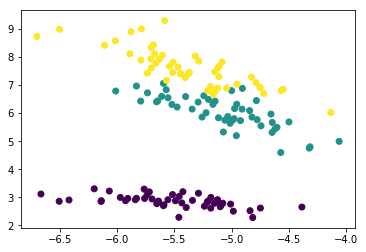

In [0]:
sess = tf.Session(graph=graph)
# 주성분이 2개인 경우 시각화을 진행합니다. 
# x 축에 z , y 축에 z 을 
pca_result = sess.run(z, feed_dict={x : data, num_pc : 2}  ) 
print(pca_result.shape)
plt.scatter(pca_result[:,0] ,pca_result[:,1] , c=target)
plt.show()

(150, 3)


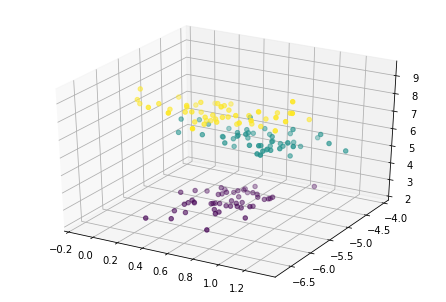

In [0]:
# 주성분이 3개인 경우 시각화을 진행합니다. 
pca_result_3 = sess.run(z, feed_dict={x : data, num_pc : 3})
print(pca_result_3.shape)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca_result_3[:,0] ,pca_result_3[:,1], pca_result_3[:,2], c=target)
plt.show()